<a href="https://colab.research.google.com/github/pack0shades/understanding_backpropagation/blob/main/undrstingbackpropgation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install micrograd

In [ ]:
from micrograd.engine import Value

In [ ]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

BASICS

##A simple function

In [ ]:
def F(x):
  return 5*x**2 + 4*x -7

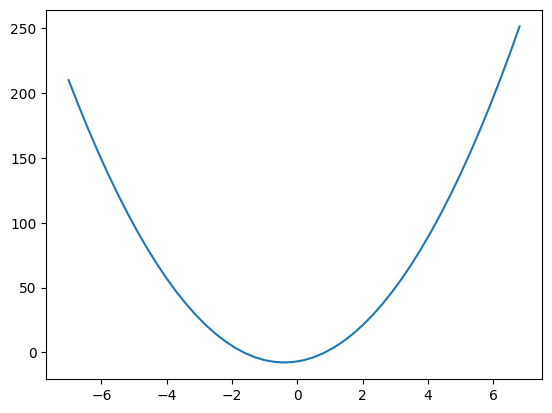

In [ ]:
x = np.arange(-7,7,0.3)
y = F(x)
plt.plot(x,y)

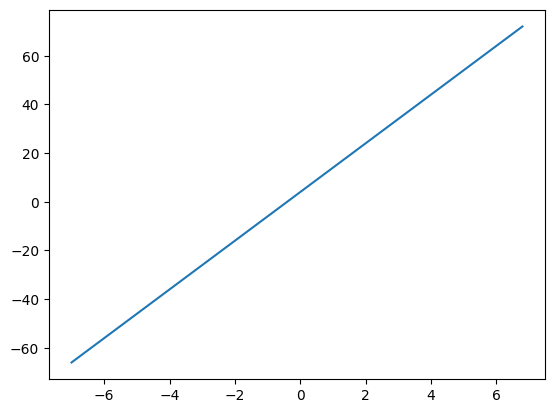

In [ ]:
h = .00001
yd = (F(x+h) - F(x))/h
plt.plot(x,yd)

##lets go to a new function

In [ ]:
class Value:
  def __init__(self,data,_children=(),_op='',label=''):
    self.data = data
    self.grad = 0.0
    self._backward = lambda: None
    self._prev = set(_children)
    self.label = label
    self._op = _op

  def __repr__(self):
    return f"Value(data={self.data})"

  def __add__(self,other):
    other = other if isinstance(other,Value) else Value(other)
    out = Value(self.data + other.data,(self,other),'+')

    def _backward():
      self.grad += 1.0*out.grad
      other.grad += 1.0*out.grad

    out._backward = _backward
    return out

  def __radd__(self, other):
    return self.__add__(other)  #if order is reversed in * operator


  def __neg__(self):
    return self * -1

  def __mul__(self,other):
    other = other if isinstance(other,Value) else Value(other)
    out = Value(self.data*other.data,(self, other),'*')

    def _backward():
      self.grad += other.data*out.grad
      other.grad += self.data*out.grad

    out._backward = _backward
    return out

  def __rmul__(self, other):
        return self.__mul__(other)  #if order is reversed in * operator


  def __pow__(self,other):
    assert isinstance(other,(int,float))
    out = Value(self.data**other,(self,), f'**{other}')

    def _backward():
      self.grad += other*self.data**(other - 1) * out.grad

    out._backward = _backward

    return out


  def __sub__(self,other):
    other = other if isinstance(other,Value) else Value(other)
    return self + (-other)

  def __truediv__(self,other):
    return self *(other)**-1

  def tanh(self):
    x = self.data
    t = (math.exp(2*x)-1)/(math.exp(2*x) +1)
    out = Value(t,(self,),'tanh')

    def _backward():
      self.grad += (1-t**2)*out.grad

    out._backward = _backward
    return out

  def exp(self):
    x = self.data
    out = Value(math.exp(x),(self, ),'exp')

    def _backward():
      self.grad = out.data*out.grad
    out._backward = _backward

    return out


  def backward(self):
    topo = []
    visited = set()
    def build_topo(v):
      if v not in visited:
        visited.add(v)
        for child in v._prev:
          build_topo(child)
        topo.append(v)
    build_topo(self)

    self.grad = 1.0
    for node in reversed(topo):
      node._backward()



a = Value(4.0,label = 'a')
b = Value(-2.0,label = 'b')
c = Value(10.0,label = 'c')
e = a*c;e.label ='e'
d = e - b;d.label = 'd'
f = Value(-3.0,label = 'f')
L = d*f;L.label = 'L'
print(L)

Value(data=-126.0)


In [ ]:
L._prev

{Value(data=-3.0), Value(data=42.0)}

now to understand the backpropgation we will find out gradient of L WRT to all the other variables,
and to represent this we gonna make a flow chart with the help of graphviz

In [ ]:
from graphviz import Digraph

def trace(root):
  nodes, edges = set(),set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges .add((child,v))
        build(child)
  build(root)
  return nodes, edges


def draw_dot(root):
  dot = Digraph(format = 'svg',graph_attr={'rankdir':'LR'})

  nodes,edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    dot.node(name = uid,label = "{%s| data %.4f | grad %.4f}" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      dot.node(name= uid +n._op, label = n._op)
      dot.edge(uid +n._op, uid)

  for n1,n2 in edges:
    dot.edge(str(id(n1)),str(id(n2))+ n2._op)
  return dot

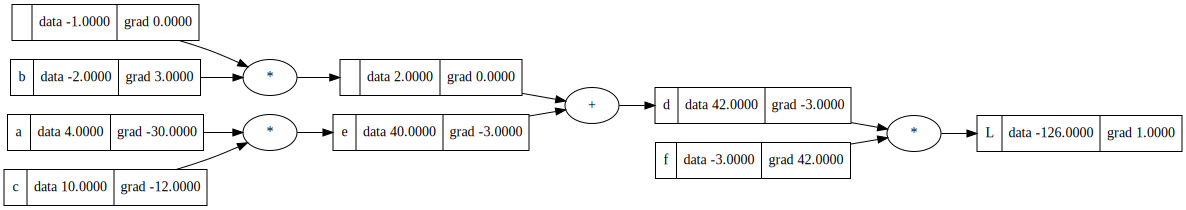

In [ ]:
draw_dot(L)

here der() can be used to find the derivative of l WRT all other variable just add h in the L2 part of that variable and the function will print the derivative.

In [ ]:
def der():

  a = Value(4.0,label = 'a')
  b = Value(-2.0,label = 'b')
  c = Value(10.0,label = 'c')
  e = a*c;e.label ='e'
  d = e - b;d.label = 'd'
  f = Value(-3.0,label = 'f')
  L = d*f;L.label = 'L'
  L1 = L.data

  a = Value(4.0,label = 'a')
  b = Value(-2.0,label = 'b')
  c = Value(10.0,label = 'c')
  e = a*c;e.label ='e'
  d = e - b;d.label = 'd'
  f = Value(-3.0,label = 'f')
  L = d*f;L.label = 'L'
  L2 = L.data + h
  print((L2-L1)/h)
der()

1.0000000003174137


In [ ]:
#by using above function we can find all the gradient and can verify manually by chain rule
L.grad = 1.0
d.grad = -3.0
f.grad = 42.0
e.grad = -3.0
b.grad = 3.0
a.grad = -30.0
c.grad = -12.0

##Now let's do manual backpropagation in a simple neural network a two layer perceptron.

In [ ]:
#inputs are x1 and x2 and let the activation function be tanh
x1 = Value(3.0,label = 'x1')
x2 = Value(7.0,label = 'x2')
#weights
w1 = Value(-4.0,label = 'w1')
w2 = Value(1.0,label = 'w2')
#bias
b= Value(2.534524,label='bias')
'''we are making seperate variable for each so that we can find grad as we done aboveground this is nothing but just x1*w1 + x2*w2 + bias'''
x1w1 = x1*w1;x1w1.label = 'x1w1'
x2w2 = x2*w2; x2w2.label = 'x2w2'
x1w1x2w2 = x1w1 + x2w2;x1w1x2w2.label = 'x1w1 + x2w2'
n = x1w1x2w2 + b; n.label = 'n'
out = n.tanh(); out.label = 'out'

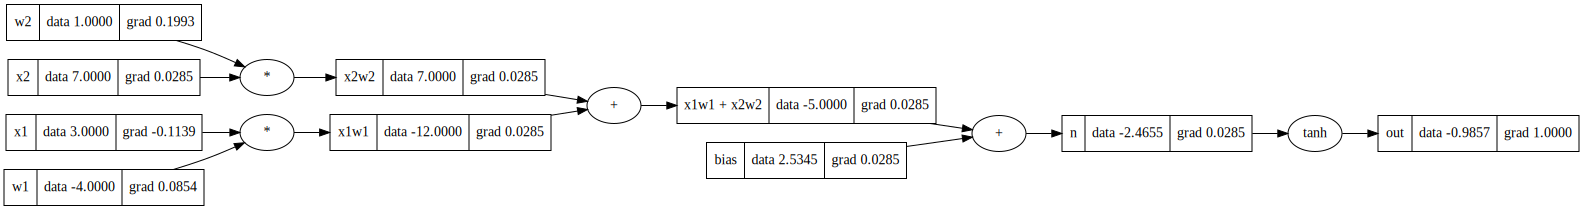

In [ ]:
draw_dot(out)

In [ ]:
out.backward()

In [ ]:
'''either do this using ._backward method or do the manual backpropagation or can
simply call backward() which is defined in the value class which first build topological
order in which self object comes after all its child node are present then run a loop for ._backward() function
which is combinely done in backward function.'''
out.grad = 1.0
out._backward()
n._backward()
b._backward()
x1w1x2w2._backward()
x2w2._backward()
x1w1._backward()

In [ ]:
out.grad = 1.0
n.grad = 1.0- out.data**2
b.grad = n.grad
x1w1x2w2.grad = n.grad
x1w1.grad = x1w1x2w2.grad
x2w2.grad = x1w1x2w2.grad
x2.grad = (x2w2.grad)*(w2.data)
x1.grad = (x1w1.grad)*(w1.data)
w1.grad = (x1w1.grad)*(x1.data)
w2.grad = (x2w2.grad)*(x2.data)

now lets break down the tanh function

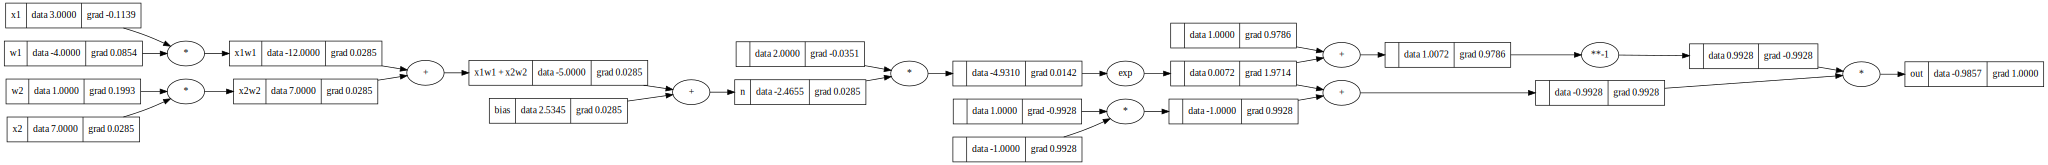

In [ ]:
#inputs are x1 and x2 and let the activation function be tanh
x1 = Value(3.0,label = 'x1')
x2 = Value(7.0,label = 'x2')
#weights
w1 = Value(-4.0,label = 'w1')
w2 = Value(1.0,label = 'w2')
#bias
b= Value(2.534524,label='bias')
'''we are making seperate variable for each so that we can find grad as we done aboveground this is nothing but just x1*w1 + x2*w2 + bias
    for this purpose wi have introduced many new methods in class Values such as exp, truediv etc.'''
x1w1 = x1*w1;x1w1.label = 'x1w1'
x2w2 = x2*w2; x2w2.label = 'x2w2'
x1w1x2w2 = x1w1 + x2w2;x1w1x2w2.label = 'x1w1 + x2w2'
n = x1w1x2w2 + b; n.label = 'n'

e = (n*2).exp()
out = (e-1)/(e+1)
out.label = 'out'
out.backward()
draw_dot(out)

## Now lets do the exact same thing in pytorch

In [ ]:
import torch

In [ ]:
##we will make tensors of each input and weights by default due to efficiency reasons gradient are set to false so have to set them to true

x1 = torch.Tensor([3.0]).double();x1.requires_grad = True
x2 = torch.Tensor([7.0]).double();x2.requires_grad = True
w1 = torch.Tensor([-4.0]).double();w1.requires_grad = True
w2 = torch.Tensor([1.0]).double();w2.requires_grad = True
b = torch.Tensor([2.5345]).double();b.requires_grad = True
n = x1*w1 + x2*w2 +b
out = torch.tanh(n)

print(out.data.item())
out.backward()
print('x2',x2.grad.item())
print('w2',w2.grad.item())
print('x1',x1.grad.item())
print('w1',w1.grad.item())

-0.9856649314348199
x2 0.028464642939591736
w2 0.19925250057714217
x1 -0.11385857175836694
w1 0.08539392881877521


In [ ]:


class Neuron:
  def __init__(self,nin):
    self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
    self.b = Value(random.uniform(-1,1))
  def __call__(self,x):
    act = sum((wi*xi for wi,xi in zip(self.w,x)), self.b)
    out = act.tanh()
    return out

  def parameters(self):
    return self.w +[self.b]

class Layer:
  def __init__ (self,nin,nout):
    self.neurons = [Neuron(nin) for _ in range(nout)]

  def __call__(self,x):
    outs = [n(x) for n in self.neurons]
    return outs[0] if len(outs) ==1 else outs

  def parameters(self):
    return [p for neuron in self.neurons for p in neuron.parameters()]

class MLP:

  def __init__(self,nin, nouts):
    sz = [nin] + nouts
    self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]

  def __call__(self,x):
    for layer in self.layers:
      x = layer(x)
    return x
  def parameters(self):
    return [p for layer in self.layers for p in layer.parameters()]

x = [2.0,3.0, -1.0]
n = MLP(3,[4,4,1])
n(x)

Value(data=0.5833885434536321)

In [ ]:
n.parameters()

[Value(data=-0.4150455815013814),
 Value(data=-0.09823386418678037),
 Value(data=-0.10613731569269369),
 Value(data=0.6677158070256182),
 Value(data=-0.0677411785358244),
 Value(data=-0.1284048158607145),
 Value(data=-0.27724415684025017),
 Value(data=-0.7270896334856938),
 Value(data=0.192924454081699),
 Value(data=0.7481792565217096),
 Value(data=-0.339152927433676),
 Value(data=0.5547297625437377),
 Value(data=-0.6921234830864584),
 Value(data=0.6741264977283596),
 Value(data=-0.8978893739973219),
 Value(data=0.8418718866175157),
 Value(data=0.12029821645461203),
 Value(data=0.4246361779932575),
 Value(data=-0.49574006058494935),
 Value(data=-0.9099705596122036),
 Value(data=-0.012579071218371762),
 Value(data=-0.14209742783200863),
 Value(data=-0.7533792727347608),
 Value(data=-0.3265960221128097),
 Value(data=-0.7956528575909774),
 Value(data=0.4656097106626409),
 Value(data=-0.5544003150501364),
 Value(data=0.656363475792294),
 Value(data=0.6728776927823286),
 Value(data=0.040105

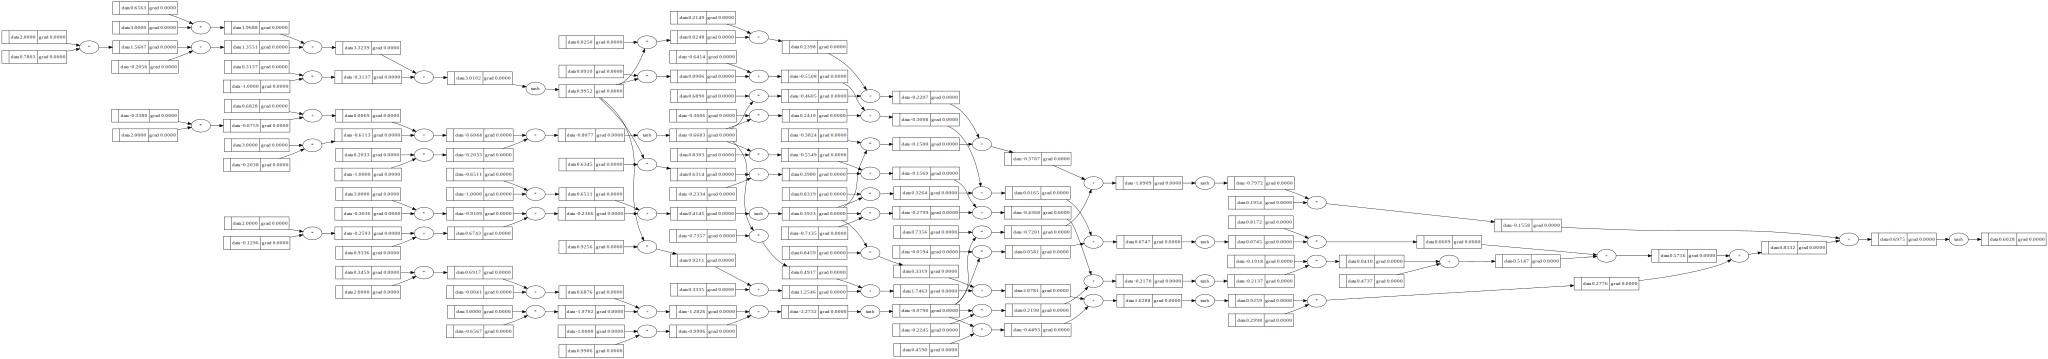

In [ ]:
draw_dot(n(x))

##this was just a random example, now i will create a small dataset of a binary classifiar and try to train it

In [ ]:
xs = [[2.0,4.0,5.0],
      [-1.0,2.0,-4.0],
      [5.0,6.0,0.0],
      [-3.0,2.0,6.0]
      ]

ys = [1.0,-1.0,1.0,-1.0]
#the logic is simple if any one of the number is less than zero than -1 otherwise 1.


In [ ]:
#single forward pass and we took a mean squared error as a loss function
ypred = [n(x) for x in xs]
loss = sum((yout- ygt)**2 for ygt,yout in zip(ys,ypred))
loss

Value(data=5.168353949344268)

In [ ]:
#after continioously iterating through the backpropagat and updating the weights i calculated the loss here to compare with the original loss
ypred = [n(x) for x in xs]
loss = sum((yout- ygt)**2 for ygt,yout in zip(ys,ypred))
loss

Value(data=0.0014724317499762727)

In [ ]:
loss.backward()

In [ ]:
for p in n.parameters():
  p.data += -0.01 * p.grad

In [ ]:
#final prediction
ypred

[Value(data=0.9999999999961561),
 Value(data=-1.0),
 Value(data=0.9999999999961545),
 Value(data=-0.9999999999091789)]

In [ ]:
#the process needs to be executed multiple times to get the desired prediction so why not put it in a loop.

for k in range (20):
  #forward pass
  ypred = [n(x) for x in xs]
  loss = sum((yout- ygt)**2 for ygt,yout in zip(ys,ypred))
  #backwardpass
  for p in n.parameters():
    p.grad = 0.0 #making gradient 0 is necessary otherwise they will accumulate as they are adding up with each iteration causing bigger steps
  loss.backward()

  #update
  for p in n.parameters():
    p.data += -0.01 * p.grad

  print(k,loss.data)


0 8.278040836344776e-21
1 8.278040836344776e-21
2 8.278040836344776e-21
3 8.278040836344776e-21
4 8.278040836344776e-21
5 8.278040836344776e-21
6 8.278040836344776e-21
7 8.278040836344776e-21
8 8.278040836344776e-21
9 8.278040836344776e-21
10 8.278040836344776e-21
11 8.278040836344776e-21
12 8.278040836344776e-21
13 8.278040836344776e-21
14 8.278040836344776e-21
15 8.278040836344776e-21
16 8.278040836344776e-21
17 8.278040836344776e-21
18 8.278040836344776e-21
19 8.278040836344776e-21


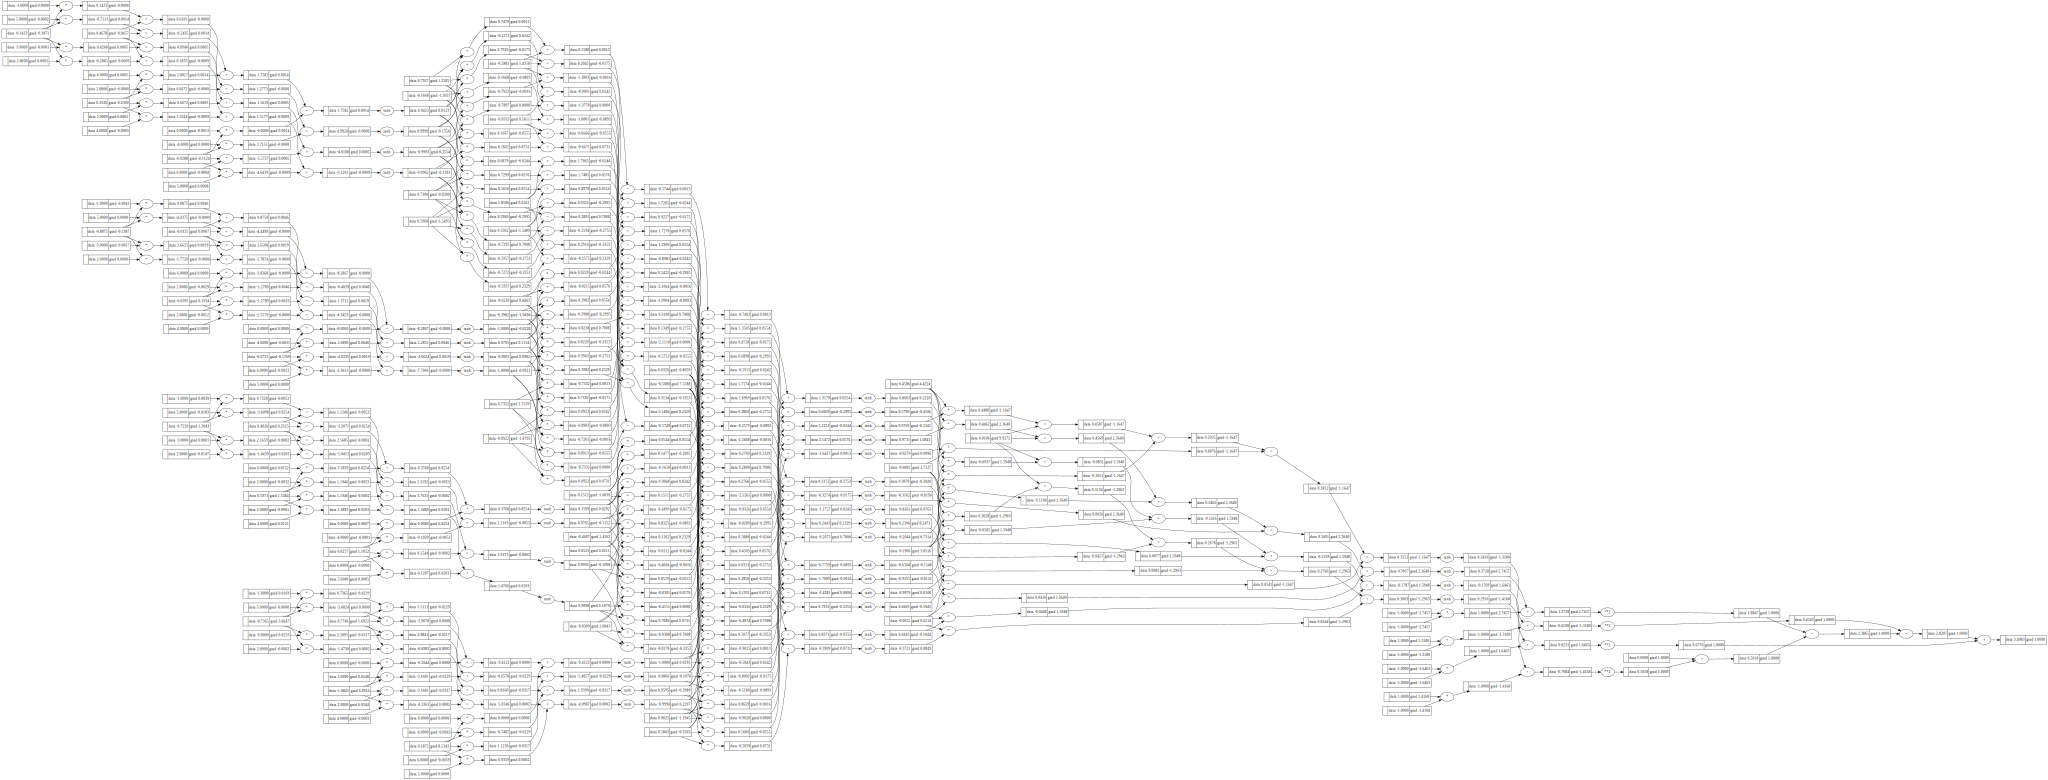

In [ ]:
draw_dot(loss)

In [ ]:
#these are the final parameters accumulation of all the weights and biases
n.parameters()

[Value(data=-0.44582016753383713),
 Value(data=-0.027664808705579094),
 Value(data=-0.8878416196012703),
 Value(data=0.409656942329167),
 Value(data=-0.8298761559571946),
 Value(data=-0.7102600670454372),
 Value(data=-0.641747053172319),
 Value(data=-0.04785929111565736),
 Value(data=-3.3348351789700983),
 Value(data=-1.1582570882342575),
 Value(data=-0.21859900053497452),
 Value(data=0.23175817878339428),
 Value(data=-7.015904148576252),
 Value(data=-0.1908117667935474),
 Value(data=-0.2141479204642651),
 Value(data=2.0630308589944515),
 Value(data=1.323292702003786),
 Value(data=0.23710067123124395),
 Value(data=-1.496239573475575),
 Value(data=-5.251271397458642),
 Value(data=-0.019771753141955756),
 Value(data=1.3059532779598138),
 Value(data=1.8561389768669012),
 Value(data=2.4508877723494695),
 Value(data=2.323521392078561),
 Value(data=0.9799189448123504),
 Value(data=0.3832541169516082),
 Value(data=0.9696851445951076),
 Value(data=-0.1724897573895799),
 Value(data=1.6883213465